In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re
import datetime
from scipy.stats import chi2_contingency, fisher_exact
from statsmodels.stats.proportion import proportions_ztest
# better table views
from IPython.display import display
# Chess game parser
import chess.pgn
from io import StringIO

In [212]:
# Utility functions
sns.set(style="darkgrid")


def fetch_json(url):
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)'}
    response = requests.get(url, headers=headers)
    
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code}")
        return {}

In [3]:
class PlayerGamesOverview:
    def __init__(self, username):
        self.link = f'https://api.chess.com/pub/player/{username}/games'
        self.username = username
        self.game_values = {
                            'checkmated': -1, 
                            'timeout': -1, 
                            'resigned': -1, 
                            'abandoned': -1, 
                            'draw': 0, 
                            'agreed': 0, 
                            'repetition': 0, 
                            'timevsinsufficient': 0, 
                            'insufficient': 0, 
                            'stalemate': 0, 
                            'win': 1
                            }
    
    def get_data(self, year, month):
        month = str(month).zfill(2)  # Ensure month is two digits
        url = f'{self.link}/{year}/{month}'
        
        self.create_player_games_table(fetch_json(url))
        # response = requests.get(url, headers=self.headers)
        # if response.status_code == 200:    
        #     data = response.json()
        #     return self.create_player_games_table(data)
        # else:
        #  print(f"Error: {response.status_code}")
    
    def create_player_games_table(self, df):
        games_data = []
        for game in df['games']:
            white_player = game["white"]["username"].lower()
            is_white = white_player == self.username.lower()
            opponent_data = game["black"] if is_white else game["white"]

            game_info = {
                "Date": game.get("end_time"),
                "Result": game["white"]["result"] if is_white else game["black"]["result"],
                "Color": "White" if is_white else "Black",
                "Opponent": opponent_data["username"],
                "Opponent Rating": opponent_data["rating"],
                "Opening": game.get("eco", "").split("/")[-1] if game.get("eco") else None,
                "Time Class": game.get("time_class", "")
            }
            games_data.append(game_info)

        # Create a DataFrame
        self.df_games = pd.DataFrame(games_data)
        self.df_games["Date"] = pd.to_datetime(self.df_games["Date"], unit='s')
        self.df_games['game_value'] = self.df_games['Result'].map(self.game_values).astype(int)
        
        return self.df_games
    
    def analyze_res_vs_opening(self):
        
        result_vs_opening = self.df_games.pivot_table(
                                        index='Opening',
                                        columns='game_value',
                                        values='Opponent',
                                        aggfunc='count',
                                        margins=True,
                                        margins_name='Sum').fillna(0).astype(int).reset_index()
        
        # top weak and strong games
        top_weak = result_vs_opening.sort_values(by=-1, ascending=False)[0:11]
        top_strong = result_vs_opening.sort_values(by=1, ascending=False)[0:11]
        
        # win rate
        sum_row = result_vs_opening[result_vs_opening['Opening'] == 'Sum']
        total_wins = sum_row[1].values[0] if 1 in sum_row else 0
        total_games = sum_row['Sum'].values[0] if 'Sum' in sum_row else 1
        win_rate = total_wins / total_games
        
        return {
        "summary_table": result_vs_opening,
        "top_weak_openings": top_weak,
        "top_strong_openings": top_strong,
        "win_rate": win_rate,
    }
        
    def analyze_res_vs_color(self):
        self.color_vs_result = self.df_games.pivot_table(
                                index='Color', 
                                columns='game_value', 
                                values='Opponent', 
                                aggfunc='count', 
                                margins=True, 
                                margins_name='Sum').fillna(0).astype(int)
        
        # Per col 
        color_vs_result_total_col = round(self.color_vs_result/self.color_vs_result.loc['Sum'], 4) * 100
        # Per row 
        color_vs_result_total_row = self.color_vs_result.div(self.color_vs_result['Sum'], axis=0)
        color_vs_result_total = round(self.color_vs_result/self.color_vs_result.loc['Sum','Sum'], 4) * 100
        
        return {
            "summary_table": self.color_vs_result,
            "share_of_total_col": color_vs_result_total_col,
            "share_of_total_row": color_vs_result_total_row,
            "share_of_total": color_vs_result_total,
            "stat_analysis": self.test_color_hypotheses(),
            "win_rate": {
                "white": self.color_vs_result.loc['White', 1] / self.color_vs_result.loc['White', 'Sum'],
                "black": self.color_vs_result.loc['Black', 1] / self.color_vs_result.loc['Black', 'Sum'],
            }
        }

    
    def test_color_hypotheses(self):
        win_counts = [self.color_vs_result.loc['White', 1], self.color_vs_result.loc['Black', 1]]
        n_obs = [self.color_vs_result.loc['White', 'Sum'], self.color_vs_result.loc['Black', 'Sum']]  
        loss_counts = [self.color_vs_result.loc['White', -1], self.color_vs_result.loc['Black', -1]]
        white_not_win = self.color_vs_result.loc['White', -1] + self.color_vs_result.loc['White', 0]
        black_not_win = self.color_vs_result.loc['Black', -1] + self.color_vs_result.loc['Black', 0]
        table = [[self.color_vs_result.loc['White', 1], white_not_win],
                [self.color_vs_result.loc['Black', 1], black_not_win]]
        return{
    # Hypothesis review
    # Hypothesis 1: Chi-Square Test of Independence
    # Do game outcomes depend on piece color (Black vs White)? / Color of piece will impact your game result!
    "chi2_p": chi2_contingency(self.color_vs_result.loc[['Black', 'White'], [-1, 0, 1]]),
    # Hypothesis 2: Two-Proportion Z-Test for Win Rates
    # Do White and Black have significantly different win rates? / White and Black win rates are significantly different!
    "ztest_win_p": proportions_ztest(count=win_counts, nobs=n_obs),
    # 3. One-tailed Z-test for loss rates 
    # Is White more likely to lose than Black? / White is more likely to lose than Black
    "ztest_loss_p":  proportions_ztest(count=loss_counts, nobs=n_obs, alternative='larger'),
    # Hypothesis 4: Fisher’s Exact Test (Win vs Not-Win)
    # Are odds of winning as White greater than Black? / Odds of winning as White are greater than Black
    "fisher_p": fisher_exact(table, alternative='greater')
    }

    
    def opponent_rating_dist(self):
        temp_rating = self.df_games['Opponent Rating']
        ax = sns.histplot(temp_rating, bins=20)
        ax.set_title('Opponent Rating Distribution')
        plt.xlabel('Opponent Rating')
        plt.ylabel('Frequency')
        plt.show()
    

In [ ]:
# TODO -- when we want the user to choose now we go an easy way to build the structure.
# self.months = {
#     1: 'January', 2: 'February', 3: 'March', 4: 'April',
#     5: 'May', 6: 'June', 7: 'July', 8: 'August',
#     9: 'September', 10: 'October', 11: 'November', 12: 'December'
# }

class GameArchives:
    """
    Fetch the last month of games data for a given player. This class g
    """
    
    def __init__(self, username):
        self.link = f'https://api.chess.com/pub/player/{username}/games/archives'
        self.username = username
        self.archives = []
        
    
    def get_latest_games(self):
        """
        Fetch latest month's game archives of the player.
        """
        game_list = fetch_json(self.link)
        if not game_list:
            raise ValueError("Could not fetch archives.")
        
        last_url = game_list['archives'][-1]
        game_data = fetch_json(last_url)
        if not game_data:
            raise ValueError("Could not fetch latest games.")
        
        self.game = game_data
        return self.game
    
    def add_moves_to_game(self):
        """
        Add moves to the game data.
        """
        games = self.game['games']
        
        for game in games:
            game['Moves'] = self.game_parser(game['pgn'])['Moves']
            
        return self.game
        

    @staticmethod
    def game_parser(pgn_text):
        """
        Parse a PGN string and return the game object.
        Requires a valid PGN string.
        """
        pgn_io = StringIO(pgn_text)
        game = chess.pgn.read_game(pgn_io)
        
        Moves = GameArchives.iterate_moves(game)
        
        return {
            'game': game,
            'Event': game.headers.get("Event"),
            'White': game.headers.get("White"),
            'Black': game.headers.get("Black"),
            'Result': game.headers.get("Result"),
            'Date': game.headers.get("Date"),
            'White Elo': game.headers.get("WhiteElo"),
            'Black Elo': game.headers.get("BlackElo"),
            'Link': game.headers.get("Link"),
            'Moves': Moves
        }


    @staticmethod
    def iterate_moves(game):
        """
        Iterate through moves in a game, attaching move_id, color, notation, and optional clock time.
        """
        res = []
        board = game.board()
        move_id = 1

        for i, move in enumerate(game.mainline_moves()):
            color = 'White' if board.turn == chess.WHITE else 'Black'
            san = board.san(move)

            node = game.end()
            current_node = game
            for _ in range(i):
                current_node = current_node.variations[0]

            clock_time = current_node.comment.strip() if "Clock" in current_node.comment else None

            res.append({
                'move_id': move_id,
                'color': color,
                'notation': san,
                'clock': clock_time
            })

            board.push(move)
            if color == 'Black':
                move_id += 1

        return res

In [233]:
class BasicChartsYearly:
    """
    A class to analyze win rates per month.
    """
    
    def __init__(self, username):
        self.username = username
        self.link = f'https://api.chess.com/pub/player/{username}/games/archives'
        self.pgo = PlayerGamesOverview(username)
        
        archive_data = fetch_json(self.link)
        urls = archive_data.get('archives', [])
        self.year_month = [tuple(url.strip('/').split('/')[-2:]) for url in urls]
        
        
    
    def get_monthly_data(self):
        """
        Calculate the win rate for each month.
        """
        monthly_data = []
        
        for _, (year, month) in enumerate(self.year_month):
            year = int(year)
            month = int(month)
            try:
                self.pgo.get_data(year, month)
                monthly_data.append({'year': year, 'month': month, 'win_rate_obj': self.pgo.win_rate()})
            except Exception as e:
                print(f"Skipped {year}-{month:02d}: {e}")
                
        monthly_data_df = pd.DataFrame(monthly_data)
        win_rate_broken = monthly_data_df['win_rate_obj'].apply(pd.Series)
        self.monthly_data_cleaned = monthly_data_df.join(win_rate_broken).drop(columns=['win_rate_obj'])
        
        return self.monthly_data_cleaned
    
    def base_plots(self):
        """
        Creates two base plots. Total games and win rate per year. Returns a df of the processed data.
        """
        df = self.get_monthly_data()
        total_games_yearly = df.groupby('year').agg({
            'total_games': 'sum',
            'total_wins': 'sum'
        })
        
        # create a year df that has all of the years from the first year to now.
        full_years = pd.Series(range(df['year'].min(), datetime.datetime.now().year + 1), name='year')
        total_games_yearly = total_games_yearly.reindex(full_years, fill_value=0)
        
        # win rate per date
        total_games_yearly['win_rate'] = round(total_games_yearly['total_wins'] / total_games_yearly['total_games'].replace(0,1) * 100, 2)
        # total win rate
        total_win_rate = round(total_games_yearly['total_wins'].sum() / total_games_yearly['total_games'].sum() * 100, 4)
        
        # Chart 1 Total games played per year
        ax1 = plt.figure(figsize=(10, 5))
        ax1 = sns.barplot(x=total_games_yearly.index, y=total_games_yearly['total_games'], palette='colorblind')
        ax1.set_title('Total Games Played Per Year')
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Total Games')
        plt.xticks(rotation=45)
        plt.show()
        
        # Chart 2 Win rate per year
        ax2 = plt.figure(figsize=(10, 5))
        ax2 = sns.lineplot(x=total_games_yearly.index, y=total_games_yearly['win_rate'], marker='o', color='orange')
        ax2.set_title('Win Rate Per Year')
        ax2.set_xlabel('Year')
        ax2.set_ylabel('Win Rate (%)')
        ax2.set_ylim(0, 100)
        plt.xticks(rotation=45)
        plt.show()
        
        return {'all_data':total_games_yearly, 'total_win_rate': total_win_rate}
    

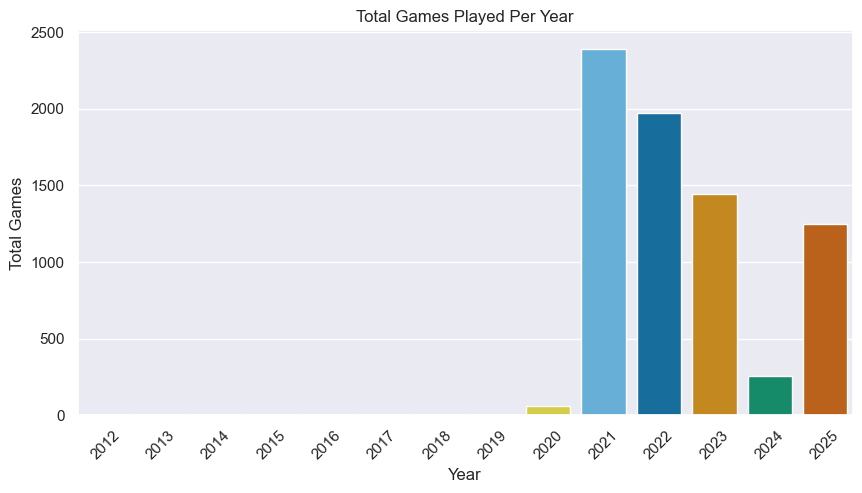

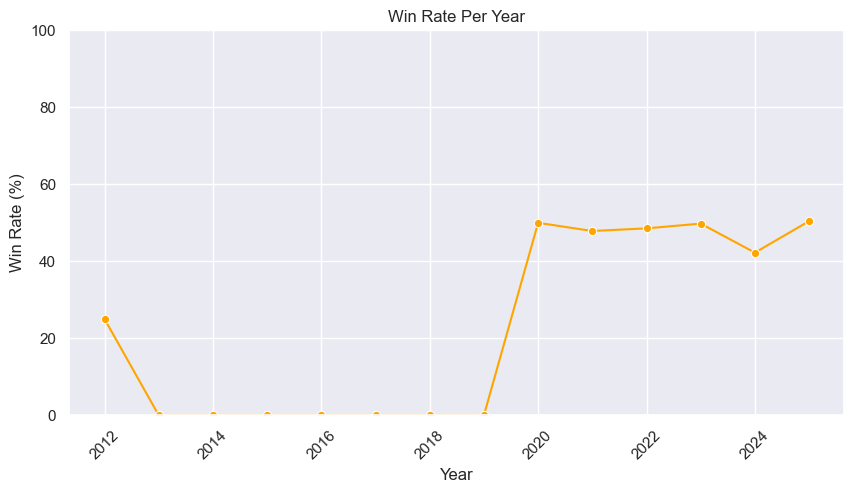

{'all_data':       total_games  total_wins  win_rate
year                                   
2012          4.0         1.0     25.00
2013          0.0         0.0      0.00
2014          0.0         0.0      0.00
2015          0.0         0.0      0.00
2016          0.0         0.0      0.00
2017          0.0         0.0      0.00
2018          0.0         0.0      0.00
2019          0.0         0.0      0.00
2020         60.0        30.0     50.00
2021       2392.0      1145.0     47.87
2022       1973.0       958.0     48.56
2023       1444.0       719.0     49.79
2024        258.0       109.0     42.25
2025       1251.0       631.0     50.44, 'total_win_rate': 48.6724}


In [235]:
bsy = BasicChartsYearly('Frezaeei')
res = bsy.base_plots()

print(res)

In [ ]:
playergameoverview = PlayerGamesOverview('Frezaeei')

playergameoverview.get_data(2025, 5)
print(playergameoverview.df_games.head())
print(playergameoverview.analyze_res_vs_opening())
print(playergameoverview.analyze_res_vs_color())
playergameoverview.opponent_rating_dist()

{'summary_table': game_value                                            Opening  -1   0   1  Sum
0                   Alapin-Sicilian-Defense-2...d5-3.exd5-Nf6   0   0   1    1
1             Alekhines-Defense-Scandinavian-Variation-3.exd5   1   0   0    1
2           Alekhines-Defense-Scandinavian-Variation-3.exd...   0   0   1    1
3                  Caro-Kann-Defense-Accelerated-Panov-Attack   0   0   1    1
4           Caro-Kann-Defense-Exchange-Variation-3...cxd5-...   0   0   1    1
..                                                        ...  ..  ..  ..  ...
104                          Slav-Defense-Modern-Line-3...Nf6   1   0   0    1
105         Slav-Defense-Modern-Quiet-Schallopp-Defense......   1   0   0    1
106           Slav-Defense-Slav-Gambit-Alekhine-Attack-4...b5   0   0   1    1
107                               Van-t-Kruijs-Opening-1...e5   0   0   2    2
108                                                       Sum  59  11  82  152

[109 rows x 5 columns], 'top_weak

In [6]:
go = GameArchives('Frezaeei')
go.get_latest_games()
res = go.add_moves_to_game()
print(res['games'][0])

{'url': 'https://www.chess.com/game/live/137982515428', 'pgn': '[Event "Live Chess"]\n[Site "Chess.com"]\n[Date "2025.05.01"]\n[Round "-"]\n[White "0043DD"]\n[Black "Frezaeei"]\n[Result "0-1"]\n[CurrentPosition "8/r7/4n1p1/p1p1k1P1/8/8/8/6K1 w - - 0 42"]\n[Timezone "UTC"]\n[ECO "C60"]\n[ECOUrl "https://www.chess.com/openings/Ruy-Lopez-Opening-Cozio-Defense"]\n[UTCDate "2025.05.01"]\n[UTCTime "11:31:52"]\n[WhiteElo "967"]\n[BlackElo "982"]\n[TimeControl "600"]\n[Termination "Frezaeei won - game abandoned"]\n[StartTime "11:31:52"]\n[EndDate "2025.05.01"]\n[EndTime "11:40:33"]\n[Link "https://www.chess.com/game/live/137982515428"]\n\n1. e4 {[%clk 0:09:58]} 1... e5 {[%clk 0:09:58.9]} 2. Nf3 {[%clk 0:09:56.2]} 2... Nc6 {[%clk 0:09:58.4]} 3. Bb5 {[%clk 0:09:49]} 3... Nge7 {[%clk 0:09:47.2]} 4. Bxc6 {[%clk 0:09:30.6]} 4... Nxc6 {[%clk 0:09:45.3]} 5. O-O {[%clk 0:09:18.2]} 5... Bc5 {[%clk 0:09:42.6]} 6. c3 {[%clk 0:08:38.8]} 6... d6 {[%clk 0:09:35.1]} 7. b4 {[%clk 0:08:37.2]} 7... Bb6 {[%clk 0

In [73]:
link = 'https://api.chess.com/pub/player/Frezaeei/games/archives'
res = fetch_json(link)
res = fetch_json(res['archives'][0])

# get the first PGN of the first game
pgn_text = res['games'][0]['pgn']
# Parse the PGN text
# game = chess.pgn.read_game(StringIO(pgn_text))
game = chess.pgn.read_game(StringIO("1. d4 e5 2. dxe5 d6 3. exd6 Bxd6 4. Nc3 Nc6 5. Nf3 Bg4 6. e4 Bxf3 7. Qxf3 a6 8. Bf4 Nd4 9. Qd3 Bxf4 "))
# Game headers
game_headers = {
                'Event': game.headers.get('Event'),
                'Site': game.headers.get('Site'),
                'Date': game.headers.get('Date'),
                'Round': game.headers.get('Round'),
                'White': game.headers.get('White'),
                'Black': game.headers.get('Black'),
                'Result': game.headers.get('Result'),
                'CurrentPosition': game.headers.get('CurrentPosition'),
                'Timezone': game.headers.get('Timezone'),
                'ECO': game.headers.get('ECO'),
                'ECOUrl': game.headers.get('ECOUrl'),
                'UTCDate': game.headers.get('UTCDate'),
                'UTCTime': game.headers.get('UTCTime'),
                'WhiteElo': game.headers.get('WhiteElo'),
                'BlackElo': game.headers.get('BlackElo'),
                'TimeControl': game.headers.get('TimeControl'),
                'Termination': game.headers.get('Termination'),
                'StartTime': game.headers.get('StartTime'),
                'EndDate': game.headers.get('EndDate'),
                'EndTime': game.headers.get('EndTime'),
                'Link': game.headers.get('Link'),
                }
# Get the list of moves
moves = list(game.mainline_moves())
# Create a chess board to push moves and create the view
board = game.board()
for move in moves:
    if move:
        board.push(move)
        chess.svg.board(board, size=350, lastmove=move)
# Get the last move
last_move = moves[-1]

# Display the board with the last move highlighted
# chess.svg.board(board, size=400, lastmove=last_move)